## Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import pymc as pm
import arviz as az
from scipy.special import expit  # sigmoid function
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.linear_model import LogisticRegression

In [48]:
filtered_df = pd.read_csv("BankMarketingAfterClean.csv")
filtered_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,False,2343,True,False,unknown,5,may,1042,1,-1,0,unknown,True
1,56,admin.,married,secondary,False,45,False,False,unknown,5,may,1467,1,-1,0,unknown,True
2,41,technician,married,secondary,False,1270,True,False,unknown,5,may,1389,1,-1,0,unknown,True
3,55,services,married,secondary,False,2476,True,False,unknown,5,may,579,1,-1,0,unknown,True
4,54,admin.,married,tertiary,False,184,False,False,unknown,5,may,673,2,-1,0,unknown,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10923,34,blue-collar,single,secondary,False,-72,True,False,cellular,7,jul,273,5,-1,0,unknown,False
10924,33,blue-collar,single,primary,False,1,True,False,cellular,20,apr,257,1,-1,0,unknown,False
10925,39,services,married,secondary,False,733,False,False,unknown,16,jun,83,4,-1,0,unknown,False
10926,32,technician,single,secondary,False,29,False,False,cellular,19,aug,156,2,-1,0,unknown,False


In [49]:
X = filtered_df.drop('deposit', axis=1)
y = filtered_df['deposit']

## Split the data set into training set and testing set

In [50]:
# 'stratify=y'ensures that the distribution of the target column is proportionally represented in both the training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
# Display the number of rows and column of each one
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7649, 16), (7649,), (3279, 16), (3279,))

In [51]:
numerical_cols = x_train.select_dtypes(include='number').columns
categorical_features = ["job","marital","education","default","housing","loan","contact","month","poutcome"]

## Standardization

In [52]:
# Applying standardization on the data set numerical features
scaler = StandardScaler()
# Copying original x_train and x_test
x_train_scaled = x_train.copy()
x_test_scaled = x_test.copy()
x_train_scaled[numerical_cols] = scaler.fit_transform(x_train[numerical_cols])
x_test_scaled[numerical_cols] = scaler.transform(x_test[numerical_cols])

## Gaussian Naive Bayes Algorithm with backward feature selection

In [53]:
backward_gaussian_nb= GaussianNB()
backward_gaussian_nb_sfs = SequentialFeatureSelector(backward_gaussian_nb,n_features_to_select="auto", direction='backward', scoring='accuracy')
backward_gaussian_nb_sfs.fit(x_train_scaled[numerical_cols], y_train)

SequentialFeatureSelector(direction='backward', estimator=GaussianNB(),
                          scoring='accuracy')

In [54]:
backward_gaussian_nb_selected_features = x_train_scaled[numerical_cols].columns[backward_gaussian_nb_sfs.get_support()]
print("Selected Features:", backward_gaussian_nb_selected_features)

Selected Features: Index(['age', 'duration', 'campaign', 'previous'], dtype='object')


In [55]:
x_train_backward_gaussian_nb_sfs= backward_gaussian_nb_sfs.transform(x_train_scaled[numerical_cols])
x_test_backward_gaussian_nb_sfs = backward_gaussian_nb_sfs.transform(x_test_scaled[numerical_cols])
backward_gaussian_nb.fit(x_train_backward_gaussian_nb_sfs, y_train)

GaussianNB()

In [56]:
backward_gaussian_nb_accuracy = backward_gaussian_nb.score(x_test_backward_gaussian_nb_sfs, y_test)
print("Model accuracy with Selected Features:",round(backward_gaussian_nb_accuracy, 2))
backward_gaussian_y_pred = backward_gaussian_nb.predict(x_test_backward_gaussian_nb_sfs)
print(classification_report(y_test, backward_gaussian_y_pred))

Model accuracy with Selected Features: 0.71
              precision    recall  f1-score   support

       False       0.66      0.88      0.76      1702
        True       0.80      0.52      0.63      1577

    accuracy                           0.71      3279
   macro avg       0.73      0.70      0.69      3279
weighted avg       0.73      0.71      0.70      3279



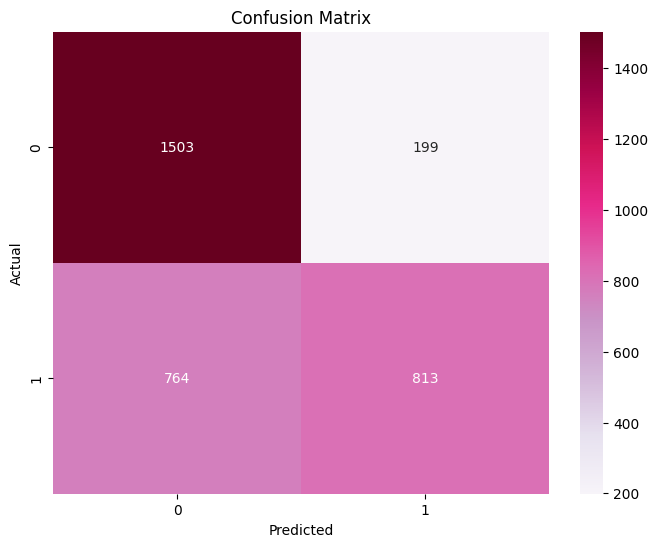

In [57]:
cm_backward_gaussian_nb = confusion_matrix(y_test, backward_gaussian_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_backward_gaussian_nb, annot=True, fmt='d', cmap='PuRd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## Encoding The Categorical features

In [58]:
encoder = OneHotEncoder(handle_unknown='ignore',sparse_output=False)
x_train_cat = encoder.fit_transform(x_train[categorical_features])
x_test_cat = encoder.transform(x_test[categorical_features])
#y_pred_cat = cat_nb.predict(x_test_cat)
feature_names = encoder.get_feature_names_out(categorical_features)
#x_train_encoded_cat = encoder.fit_transform(x_train[categorical_cols])
x_train_cat_df = pd.DataFrame(x_train_cat, columns=feature_names, index=x_train.index)
x_test_cat_df = pd.DataFrame(x_test_cat, columns=feature_names, index=x_test.index)

## Naive Bayes with backward Feature selection

In [59]:
backward_categorical_naive_bayes= CategoricalNB()
backward_categorical_nb_sfs = SequentialFeatureSelector(backward_categorical_naive_bayes,n_features_to_select="auto", direction='backward', scoring='accuracy')
backward_categorical_nb_sfs.fit(x_train_cat_df, y_train)

SequentialFeatureSelector(direction='backward', estimator=CategoricalNB(),
                          scoring='accuracy')

In [60]:
backward_categorical_nb_selected_features = x_train_cat_df.columns[backward_categorical_nb_sfs.get_support()]
print("Selected Features:", backward_categorical_nb_selected_features.tolist())

Selected Features: ['job_entrepreneur', 'job_retired', 'job_student', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'housing_False', 'housing_True', 'loan_False', 'loan_True', 'contact_cellular', 'contact_telephone', 'month_apr', 'month_dec', 'month_mar', 'month_oct', 'month_sep', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


In [61]:
x_train_backward_categorical_nb_sfs= backward_categorical_nb_sfs.transform(x_train_cat)
x_test_backward_categorical_nb_sfs = backward_categorical_nb_sfs.transform(x_test_cat)
backward_categorical_naive_bayes.fit(x_train_backward_categorical_nb_sfs, y_train)

C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(
C:\Users\DELL\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SequentialFeatureSelector was fitted with feature names
  warnings.warn(


CategoricalNB()

In [62]:
backward_categorical_nb_accuracy = backward_categorical_naive_bayes.score(x_test_backward_categorical_nb_sfs, y_test)
print("Model accuracy with Selected Features:",round(backward_categorical_nb_accuracy, 2))
backward_categorical_nb_y_pred = backward_categorical_naive_bayes.predict(x_test_backward_categorical_nb_sfs)
print(classification_report(y_test, backward_categorical_nb_y_pred))

Model accuracy with Selected Features: 0.68
              precision    recall  f1-score   support

       False       0.68      0.72      0.70      1702
        True       0.68      0.63      0.65      1577

    accuracy                           0.68      3279
   macro avg       0.68      0.67      0.67      3279
weighted avg       0.68      0.68      0.67      3279



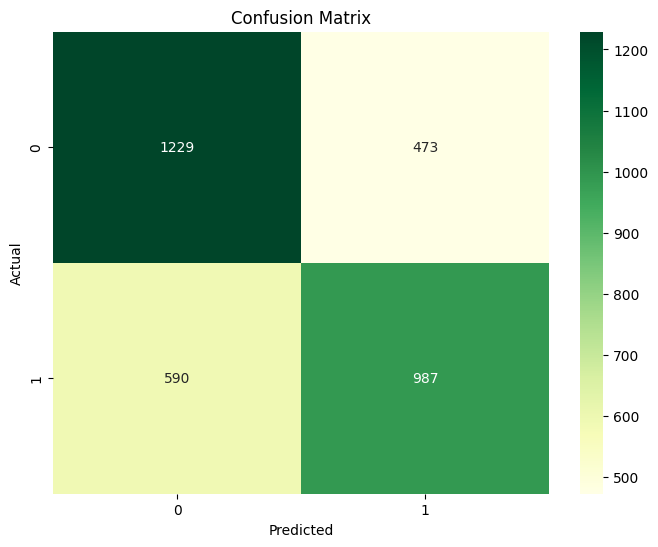

In [63]:
cm_backward_categorical_nb = confusion_matrix(y_test, backward_categorical_nb_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_backward_categorical_nb, annot=True, fmt='d', cmap='YlGn')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
user_input = input("Enter the required values ​​separated by a comma (example: age,duration,campaign,previous): ")
input_data = [float(x.strip()) for x in user_input.split(",")]
input_data = [input_data]

sample = backward_gaussian_nb.predict(input_data)
print("Model prediction:", sample)

user_input = input("Enter the required values ​​separated by a comma (example: age,duration,campaign,previous): ")
input_data = [float(x.strip()) for x in user_input.split(",")]
input_data = [input_data]

sample = backward_gaussian_nb.predict(input_data)
print("Model prediction:", sample)

# Save the model using joblib
joblib.dump(backward_gaussian_nb, 'backward_gaussian_nb_model.joblib')
print("Model saved successfully!")